In [1]:
# Basic data processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
import shutil
# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score,
    classification_report, confusion_matrix
)

# MLflow tracking
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Customer Churn Prediction")


<Experiment: artifact_location='s3://classicalmlflow/1', creation_time=1732822828408, experiment_id='1', last_update_time=1732822828408, lifecycle_stage='active', name='Customer Churn Prediction', tags={}>

In [3]:
path = kagglehub.dataset_download('blastchar/telco-customer-churn', force_download=True)
destination_path = '/root/code/MLOps_with_MLflow_Postgres/Dataset'
shutil.copytree(path, destination_path, dirs_exist_ok=True)


100%|██████████| 172k/172k [00:00<00:00, 182kB/s]

Extracting model files...


'/root/code/MLOps_with_MLflow_Postgres/Dataset'

Dataset Shape: (7043, 21)

Columns: Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   I

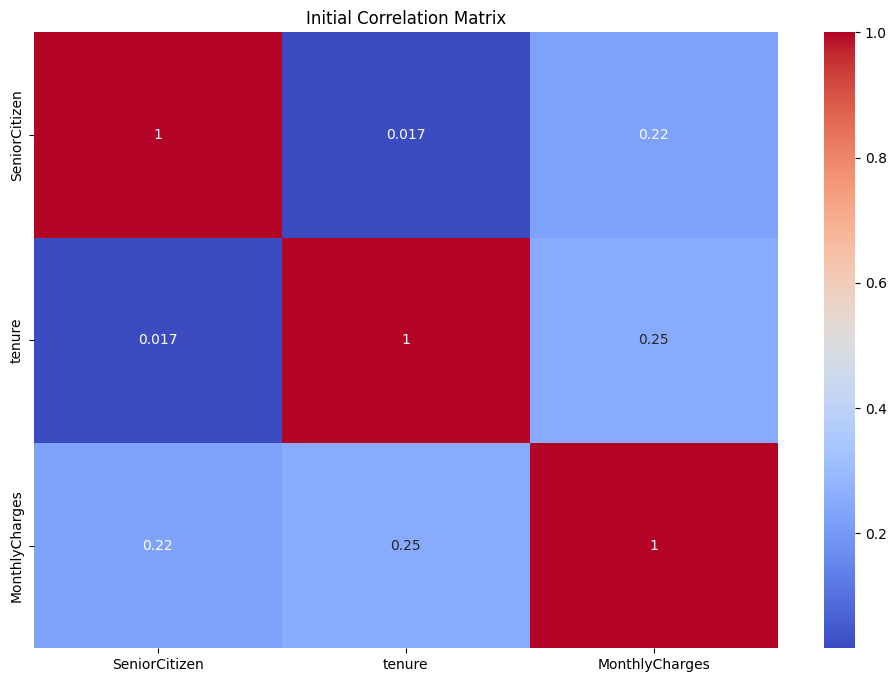

In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
import plotly.express as px
import plotly.graph_objects as go
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Load dataset and check basic information
main_df = pd.read_csv("./Dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df = main_df.copy()

# Show basic dataset information
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns)
df.info()
df.nunique()
df.describe()

# Visualize initial data distribution and correlations
# 1. Correlation Heatmap
plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Initial Correlation Matrix")
plt.show()


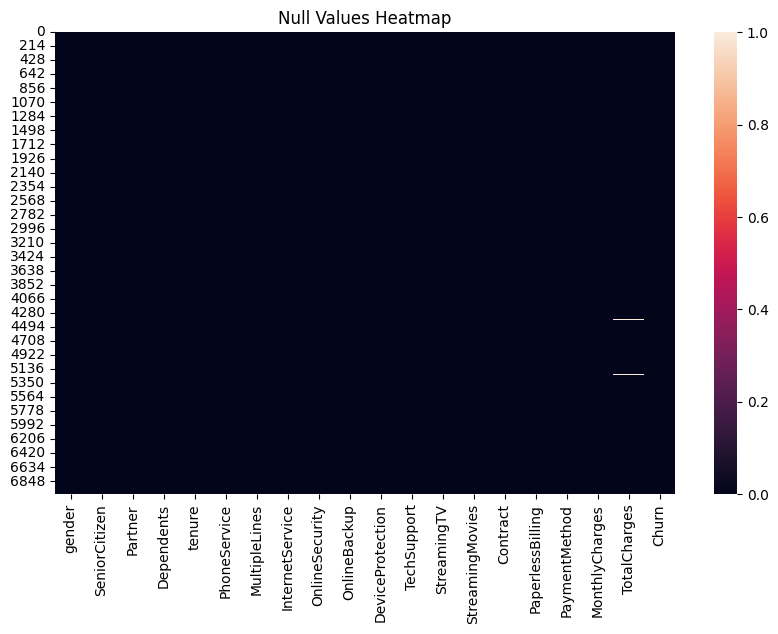

Missing Values Count:
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


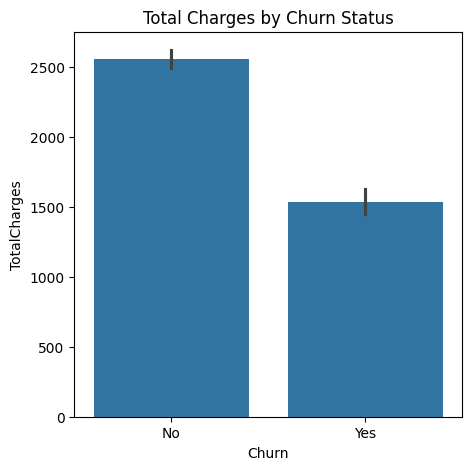

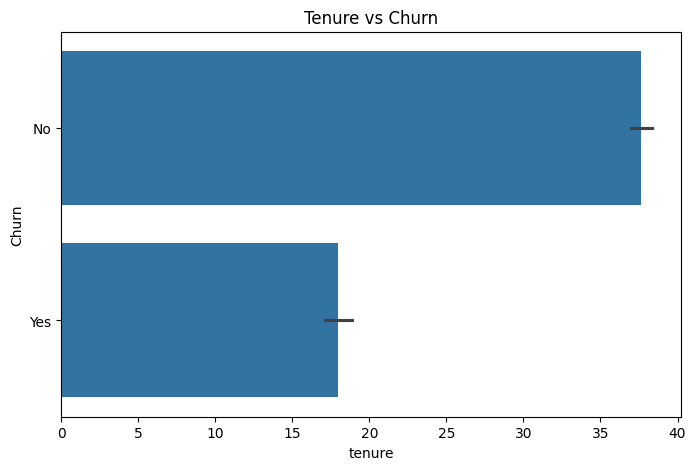

In [5]:
# Drop unnecessary columns and handle missing values
df = df.drop('customerID', axis=1)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors="coerce")

# Check and visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull())
plt.title("Null Values Heatmap")
plt.show()

print("Missing Values Count:")
print(df.isnull().sum())

# Handle missing values
df.drop(df[df['TotalCharges'].isnull()].index, inplace=True)
df.reset_index(drop=True, inplace=True)

# Visualize relationships between key features
# 1. Total Charges by Churn
plt.figure(figsize=(5, 5))
sns.barplot(data=df, y="TotalCharges", x="Churn")
plt.title("Total Charges by Churn Status")
plt.show()

# 2. Tenure vs Churn
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="tenure", y="Churn")
plt.title("Tenure vs Churn")
plt.show()

# 3. Total Charges vs Tenure
fig = px.scatter(df, y="TotalCharges", x="tenure")
fig.update_layout(title="Total Charges vs Tenure")
fig.show()


In [6]:
# Replace categorical values
df.replace('No internet service', 'No', inplace=True)
df.replace('No phone service', 'No', inplace=True)

# Display unique values in categorical columns
for i in df.columns:
    if df[i].dtypes=="object":
        print(f'{i} : {df[i].unique()}')
        print("****************************************************")

# Convert gender to numeric
df['gender'].replace({'Female':1,'Male':0}, inplace=True)


gender : ['Female' 'Male']
****************************************************
Partner : ['Yes' 'No']
****************************************************
Dependents : ['No' 'Yes']
****************************************************
PhoneService : ['No' 'Yes']
****************************************************
MultipleLines : ['No' 'Yes']
****************************************************
InternetService : ['DSL' 'Fiber optic' 'No']
****************************************************
OnlineSecurity : ['No' 'Yes']
****************************************************
OnlineBackup : ['Yes' 'No']
****************************************************
DeviceProtection : ['No' 'Yes']
****************************************************
TechSupport : ['No' 'Yes']
****************************************************
StreamingTV : ['No' 'Yes']
****************************************************
StreamingMovies : ['No' 'Yes']
****************************************************
Contract : 

In [7]:
# Churn distribution by Senior Citizen status
diag = px.histogram(df, x="Churn", color="SeniorCitizen")
diag.update_layout(width=750, height=550, title="Churn Distribution by Senior Citizen Status")
diag.show()

# Total Charges distribution by Churn
diag = px.pie(df, values='TotalCharges', names='Churn', hole=0.5)
diag.update_layout(title="Total Charges Distribution by Churn")
diag.show()


In [8]:
# 1. Multiple Lines Distribution
labels = df['MultipleLines'].unique()
values = df['MultipleLines'].value_counts()
diag = go.Figure(data=[go.Pie(labels=labels, values=values, pull=[0, 0.1, 0.2])])
diag.update_layout(
    title="Multiple Lines Distribution",
    width=600, height=400
)
diag.show()

# 2. Internet Service Distribution
labels = df['InternetService'].unique()
values = df['InternetService'].value_counts()
diag = go.Figure(data=[go.Pie(labels=labels, values=values, pull=[0, 0.2, 0.3])])
diag.update_layout(
    title="Internet Service Distribution",
    width=600, height=400
)
diag.show()

# 3. Payment Method Distribution
labels = df['PaymentMethod'].unique()
values = df['PaymentMethod'].value_counts()
diag = go.Figure(data=[go.Pie(labels=labels, values=values, pull=[0, 0, 0.2, 0])])
diag.update_layout(
    title="Payment Method Distribution",
    width=600, height=400
)
diag.show()

# 4. Contract Type Distribution
labels = df['Contract'].unique()
values = df['Contract'].value_counts()
diag = go.Figure(data=[go.Pie(labels=labels, values=values, pull=[0, 0.2, 0.3])])
diag.update_layout(
    title="Contract Type Distribution",
    width=600, height=400
)
diag.show()


In [9]:
# One-hot encoding for multi-category variables
# Handle variables with more than 2 categories
more_than_2 = ['InternetService' ,'Contract' ,'PaymentMethod']
df = pd.get_dummies(data=df, columns=more_than_2)

# Feature scaling for numerical columns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Scale continuous variables
large_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
df[large_cols] = scaler.fit_transform(df[large_cols])

# Convert binary categories to numeric
two_cate = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
            'TechSupport', 'StreamingTV', 'StreamingMovies', 
            'PaperlessBilling', 'Churn']
for i in two_cate:
    df[i].replace({"No":0, "Yes":1}, inplace=True)


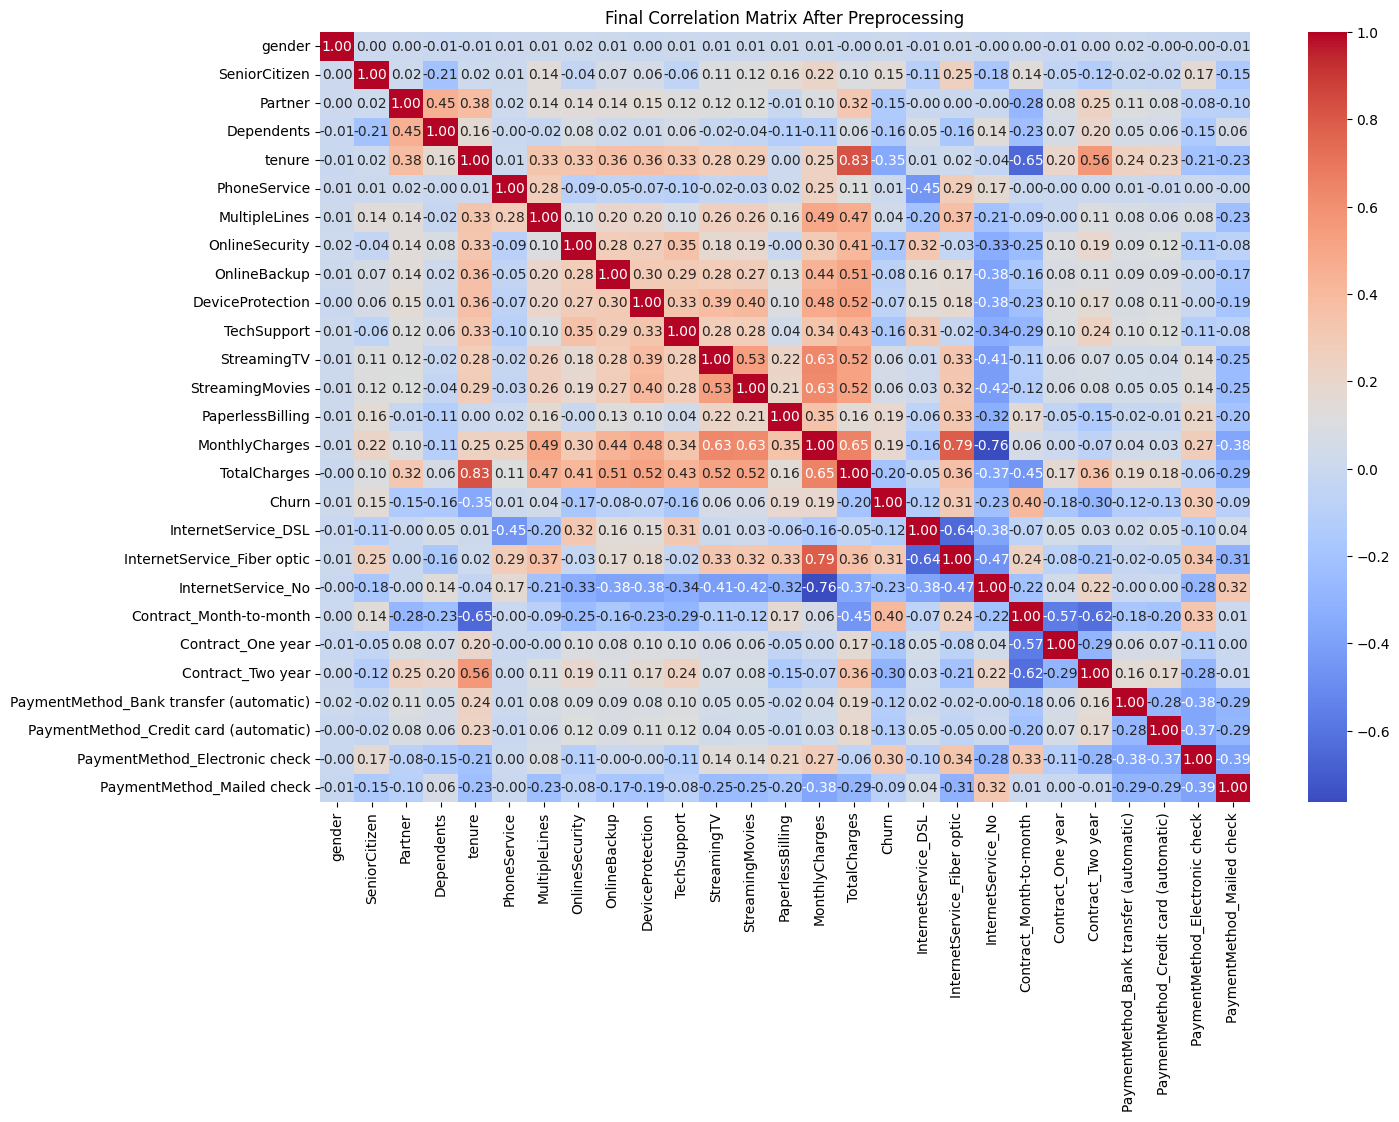

Preparing features and target...

Feature set shape: (7032, 26)
Target shape: (7032,)

Training set shape: (4711, 26)
Testing set shape: (2321, 26)


In [10]:
# Visualize final correlations after feature engineering
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Final Correlation Matrix After Preprocessing")
plt.show()

# Split features and target
print("Preparing features and target...")
X = df.drop('Churn', axis=1)
y = df['Churn']

print("\nFeature set shape:", X.shape)
print("Target shape:", y.shape)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.33, 
    random_state=42
)

print("\nTraining set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mlflow
from mlflow.models import infer_signature

with mlflow.start_run(run_name="logistic_regression"):
    # Create and train model
    model_lg = LogisticRegression(max_iter=120, random_state=0, n_jobs=20)
    
    # Log parameters
    mlflow.log_params({
        "max_iter": 120,
        "random_state": 0,
        "n_jobs": 20
    })
    
    # Train model
    model_lg.fit(X_train, y_train)
    
    # Make predictions
    pred_lg = model_lg.predict(X_test)
    
    # Calculate and log accuracy
    lg = round(accuracy_score(y_test, pred_lg) * 100, 2)
    mlflow.log_metric("accuracy", lg)
    
    # Log classification report
    clf_report = classification_report(y_test, pred_lg)
    with open("lg_classification_report.txt", "w") as f:
        f.write(clf_report)
    mlflow.log_artifact("lg_classification_report.txt")
    
    # Create and log confusion matrix
    plt.figure(figsize=(8, 6))
    cm1 = confusion_matrix(y_test, pred_lg)
    sns.heatmap(cm1 / np.sum(cm1), annot=True, fmt='.2%', cmap="Reds")
    plt.title("Logistic Regression Confusion Matrix")
    plt.savefig("lg_confusion_matrix.png")
    plt.close()
    mlflow.log_artifact("lg_confusion_matrix.png")
    
    # Calculate and log additional metrics
    precision = precision_score(y_test, pred_lg)
    recall = recall_score(y_test, pred_lg)
    f1 = f1_score(y_test, pred_lg)
    mlflow.log_metrics({
        "precision": precision,
        "recall": recall,
        "f1": f1
    })
    
    # Log the model
    signature = infer_signature(X_train, pred_lg)
    mlflow.sklearn.log_model(model_lg, "logistic_regression_model", signature=signature)

print(f"Logistic Regression Accuracy: {lg}%")
print("Classification Report:")
print(clf_report)


2024/11/28 20:22:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run logistic_regression at: http://localhost:5000/#/experiments/1/runs/48d09e7e0c434db5b57724ef1c086738.
2024/11/28 20:22:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.


Logistic Regression Accuracy: 80.01%
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1711
           1       0.64      0.54      0.58       610

    accuracy                           0.80      2321
   macro avg       0.74      0.72      0.73      2321
weighted avg       0.79      0.80      0.79      2321



In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mlflow
from mlflow.models import infer_signature

with mlflow.start_run(run_name="decision_tree"):
    # Create and train model
    model_dt = DecisionTreeClassifier(max_depth=4, random_state=42)
    
    # Log parameters
    mlflow.log_params({
        "max_depth": 4,
        "random_state": 42
    })
    
    # Train model
    model_dt.fit(X_train, y_train)
    
    # Make predictions
    pred_dt = model_dt.predict(X_test)
    
    # Calculate and log accuracy
    dt = round(accuracy_score(y_test, pred_dt) * 100, 2)
    mlflow.log_metric("accuracy", dt)
    
    # Log classification report
    clf_report = classification_report(y_test, pred_dt)
    with open("dt_classification_report.txt", "w") as f:
        f.write(clf_report)
    mlflow.log_artifact("dt_classification_report.txt")
    
    # Create and log confusion matrix
    plt.figure(figsize=(8, 6))
    cm2 = confusion_matrix(y_test, pred_dt)
    sns.heatmap(cm2 / np.sum(cm2), annot=True, fmt='.2%', cmap="Reds")
    plt.title("Decision Tree Classifier Confusion Matrix")
    plt.savefig("dt_confusion_matrix.png")
    plt.close()
    mlflow.log_artifact("dt_confusion_matrix.png")
    
    # Calculate and log additional metrics
    precision = precision_score(y_test, pred_dt, average="weighted")
    recall = recall_score(y_test, pred_dt, average="weighted")
    f1 = f1_score(y_test, pred_dt, average="weighted")
    mlflow.log_metrics({
        "precision": precision,
        "recall": recall,
        "f1": f1
    })
    
    # Log the model
    signature = infer_signature(X_train, pred_dt)
    mlflow.sklearn.log_model(model_dt, "decision_tree_model", signature=signature)

print(f"Decision Tree Accuracy: {dt}%")
print("\nClassification Report:")
print(clf_report)


2024/11/28 20:22:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run decision_tree at: http://localhost:5000/#/experiments/1/runs/31a673ea5ee440f5aa9c5b2d980d9d8c.
2024/11/28 20:22:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.


Decision Tree Accuracy: 78.89%

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1711
           1       0.63      0.48      0.54       610

    accuracy                           0.79      2321
   macro avg       0.73      0.69      0.70      2321
weighted avg       0.78      0.79      0.78      2321



In [13]:
from sklearn.ensemble import RandomForestClassifier

with mlflow.start_run(run_name="random_forest"):
    # Create and train model
    model_rf = RandomForestClassifier(n_estimators=300, min_samples_leaf=0.16, random_state=42)
    
    # Log parameters
    mlflow.log_params({
        "n_estimators": 300,
        "min_samples_leaf": 0.16,
        "random_state": 42
    })
    
    # Train model
    model_rf.fit(X_train, y_train)
    
    # Make predictions
    pred_rf = model_rf.predict(X_test)
    
    # Calculate and log accuracy
    rf = round(accuracy_score(y_test, pred_rf) * 100, 2)
    mlflow.log_metric("accuracy", rf)
    
    # Log classification report
    clf_report = classification_report(y_test, pred_rf)
    with open("rf_classification_report.txt", "w") as f:
        f.write(clf_report)
    mlflow.log_artifact("rf_classification_report.txt")
    
    # Create and log confusion matrix
    plt.figure(figsize=(8, 6))
    cm3 = confusion_matrix(y_test, pred_rf)
    sns.heatmap(cm3 / np.sum(cm3), annot=True, fmt='.2%', cmap="Reds")
    plt.title("Random Forest Confusion Matrix")
    plt.savefig("rf_confusion_matrix.png")
    plt.close()
    mlflow.log_artifact("rf_confusion_matrix.png")
    
    # Calculate and log additional metrics
    precision = precision_score(y_test, pred_rf, average="weighted")
    recall = recall_score(y_test, pred_rf, average="weighted")
    f1 = f1_score(y_test, pred_rf, average="weighted")
    mlflow.log_metrics({
        "precision": precision,
        "recall": recall,
        "f1": f1
    })
    
    # Log feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model_rf.feature_importances_
    }).sort_values('importance', ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
    plt.title("Top 10 Feature Importance - Random Forest")
    plt.savefig("rf_feature_importance.png")
    plt.close()
    mlflow.log_artifact("rf_feature_importance.png")
    
    # Log the model
    signature = infer_signature(X_train, pred_rf)
    mlflow.sklearn.log_model(model_rf, "random_forest_model", signature=signature)

print(f"Random Forest Metrics: Accuracy={rf}%, Precision={precision}, Recall={recall}, F1={f1}")


2024/11/28 20:23:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run random_forest at: http://localhost:5000/#/experiments/1/runs/fb7b5362e4114473832da10e28888b08.
2024/11/28 20:23:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.


Random Forest Metrics: Accuracy=73.72%, Precision=0.5434376682857992, Recall=0.7371822490305903, F1=0.6256541806008632


In [14]:
from xgboost import XGBClassifier

with mlflow.start_run(run_name="xgboost"):
    # Create and train model
    model_xgb = XGBClassifier(max_depth=8, n_estimators=125, random_state=0, 
                              learning_rate=0.03, n_jobs=5)
    
    # Log parameters
    mlflow.log_params({
        "max_depth": 8,
        "n_estimators": 125,
        "learning_rate": 0.03,
        "random_state": 0,
        "n_jobs": 5
    })
    
    # Train model
    model_xgb.fit(X_train, y_train)
    
    # Make predictions
    pred_xgb = model_xgb.predict(X_test)
    
    # Calculate and log accuracy
    xgb = round(accuracy_score(y_test, pred_xgb) * 100, 2)
    mlflow.log_metric("accuracy", xgb)
    
    # Log classification report
    clf_report = classification_report(y_test, pred_xgb)
    with open("xgb_classification_report.txt", "w") as f:
        f.write(clf_report)
    mlflow.log_artifact("xgb_classification_report.txt")
    
    # Log confusion matrix
    plt.figure(figsize=(8, 6))
    cm4 = confusion_matrix(y_test, pred_xgb)
    sns.heatmap(cm4 / np.sum(cm4), annot=True, fmt='.2%', cmap="Reds")
    plt.title("XGBoost Confusion Matrix")
    plt.savefig("xgb_confusion_matrix.png")
    plt.close()
    mlflow.log_artifact("xgb_confusion_matrix.png")
    
    # Log model
    signature = infer_signature(X_train, pred_xgb)
    mlflow.sklearn.log_model(model_xgb, "xgboost_model", signature=signature)

print(f"XGBoost Metrics: Accuracy={xgb}%, Precision={precision}, Recall={recall}, F1={f1}")


2024/11/28 20:24:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run xgboost at: http://localhost:5000/#/experiments/1/runs/e9ef7c65772e488eb655bdaea27e0b0a.
2024/11/28 20:24:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.


XGBoost Metrics: Accuracy=79.06%, Precision=0.5434376682857992, Recall=0.7371822490305903, F1=0.6256541806008632


In [15]:
from sklearn.neighbors import KNeighborsClassifier

with mlflow.start_run(run_name="kneighbors"):
    # Create model
    model_kn = KNeighborsClassifier(n_neighbors=9, leaf_size=20)
    
    # Log parameters
    mlflow.log_params({
        "n_neighbors": 9,
        "leaf_size": 20
    })
    
    # Train model
    model_kn.fit(X_train, y_train)
    
    # Make predictions
    pred_kn = model_kn.predict(X_test)
    
    # Calculate and log accuracy
    kn = round(accuracy_score(y_test, pred_kn) * 100, 2)
    mlflow.log_metric("accuracy", kn)
    
    # Log classification report
    clf_report = classification_report(y_test, pred_kn)
    with open("kn_classification_report.txt", "w") as f:
        f.write(clf_report)
    mlflow.log_artifact("kn_classification_report.txt")
    
    # Log confusion matrix
    plt.figure(figsize=(8, 6))
    cm5 = confusion_matrix(y_test, pred_kn)
    sns.heatmap(cm5 / np.sum(cm5), annot=True, fmt='.2%', cmap="Reds")
    plt.title("KNeighbors Confusion Matrix")
    plt.savefig("kn_confusion_matrix.png")
    plt.close()
    mlflow.log_artifact("kn_confusion_matrix.png")
    
    # Log model
    signature = infer_signature(X_train, pred_kn)
    mlflow.sklearn.log_model(model_kn, "kneighbors_model", signature=signature)

print(f"KNeighbors Metrics: Accuracy={kn}%, Precision={precision}, Recall={recall}, F1={f1}")


2024/11/28 20:24:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run kneighbors at: http://localhost:5000/#/experiments/1/runs/00ea66b369464fcfbc4c09cf47f2e105.
2024/11/28 20:24:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.


KNeighbors Metrics: Accuracy=76.99%, Precision=0.5434376682857992, Recall=0.7371822490305903, F1=0.6256541806008632


In [16]:
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mlflow
from mlflow.models import infer_signature

with mlflow.start_run(run_name="svm_classifier"):
    # Create and train model
    model_svm = SVC(kernel='rbf', random_state=42)
    
    # Log parameters
    mlflow.log_params({
        "kernel": "rbf",
        "random_state": 42
    })
    
    # Train model
    model_svm.fit(X_train, y_train)
    
    # Make predictions
    pred_svm = model_svm.predict(X_test)
    
    # Calculate and log accuracy
    sv = round(accuracy_score(y_test, pred_svm)*100, 2)
    mlflow.log_metric("accuracy", sv)
    
    # Log classification report
    clf_report = classification_report(y_test, pred_svm)
    with open("svm_classification_report.txt", "w") as f:
        f.write(clf_report)
    mlflow.log_artifact("svm_classification_report.txt")
    
    # Create and log confusion matrix
    plt.figure(figsize=(8, 6))
    cm6 = confusion_matrix(y_test, pred_svm)
    sns.heatmap(cm6/np.sum(cm6), annot=True, fmt='0.2%', cmap="Reds")
    plt.title("SVM Classifier Confusion Matrix")
    plt.savefig("svm_confusion_matrix.png")
    plt.close()
    mlflow.log_artifact("svm_confusion_matrix.png")
    
    # Log additional metrics
    mlflow.log_metrics({
        "precision": precision_score(y_test, pred_svm),
        "recall": recall_score(y_test, pred_svm),
        "f1": f1_score(y_test, pred_svm)
    })
    
    # Log the model
    signature = infer_signature(X_train, pred_svm)
    mlflow.sklearn.log_model(model_svm, "svm_model", signature=signature)

print(f"SVM Classifier Accuracy: {sv}%")
print("\nClassification Report:")
print(classification_report(y_test, pred_svm))


2024/11/28 20:25:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run svm_classifier at: http://localhost:5000/#/experiments/1/runs/fd27cf5783df412ead50baba0fb34d03.
2024/11/28 20:25:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.


SVM Classifier Accuracy: 79.84%

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1711
           1       0.65      0.50      0.57       610

    accuracy                           0.80      2321
   macro avg       0.74      0.70      0.72      2321
weighted avg       0.79      0.80      0.79      2321



In [17]:
from sklearn.ensemble import AdaBoostClassifier

with mlflow.start_run(run_name="adaboost"):
    # Create model
    model_ada = AdaBoostClassifier(
        learning_rate=0.002,
        n_estimators=205,
        random_state=42
    )
    
    # Log parameters
    mlflow.log_params({
        "learning_rate": 0.002,
        "n_estimators": 205,
        "random_state": 42
    })
    
    # Train model
    model_ada.fit(X_train, y_train)
    
    # Make predictions
    pred_ada = model_ada.predict(X_test)
    
    # Calculate and log accuracy
    ada = round(accuracy_score(y_test, pred_ada) * 100, 2)
    mlflow.log_metric("accuracy", ada)
    
    # Log classification report
    clf_report = classification_report(y_test, pred_ada)
    with open("ada_classification_report.txt", "w") as f:
        f.write(clf_report)
    mlflow.log_artifact("ada_classification_report.txt")
    
    # Log confusion matrix
    plt.figure(figsize=(8, 6))
    cm7 = confusion_matrix(y_test, pred_ada)
    sns.heatmap(cm7 / np.sum(cm7), annot=True, fmt='.2%', cmap="Reds")
    plt.title("AdaBoost Confusion Matrix")
    plt.savefig("ada_confusion_matrix.png")
    plt.close()
    mlflow.log_artifact("ada_confusion_matrix.png")
    
    # Log feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model_ada.feature_importances_
    }).sort_values('importance', ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
    plt.title("Top 10 Feature Importance - AdaBoost")
    plt.savefig("ada_feature_importance.png")
    plt.close()
    mlflow.log_artifact("ada_feature_importance.png")
    
    # Log model
    signature = infer_signature(X_train, pred_ada)
    mlflow.sklearn.log_model(model_ada, "adaboost_model", signature=signature)

print(f"AdaBoost Metrics: Accuracy={ada}%, Precision={precision}, Recall={recall}, F1={f1}")


2024/11/28 20:26:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run adaboost at: http://localhost:5000/#/experiments/1/runs/4327974c19c445799395198f08106360.
2024/11/28 20:26:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.


AdaBoost Metrics: Accuracy=73.72%, Precision=0.5434376682857992, Recall=0.7371822490305903, F1=0.6256541806008632


In [18]:
# Create and log model comparison visualization in MLflow
with mlflow.start_run(run_name="model_comparison"):
    # Create DataFrame with model performances
    models = pd.DataFrame({
        'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 
                'XGBoost', 'KNN', 'SVM', 'AdaBoost'],
        'Accuracy': [lg, dt, rf, xgb, kn, sv, ada]
    })
    
    # Create comparison plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Accuracy', y='Model', data=models)
    plt.title('Model Performance Comparison')
    plt.xlabel('Accuracy Score (%)')
    plt.ylabel('Models')
    
    # Save plot
    plt.savefig("model_comparison.png")
    plt.close()
    
    # Log the comparison plot
    mlflow.log_artifact("model_comparison.png")
    
    # Log individual model accuracies
    for model, accuracy in zip(models['Model'], models['Accuracy']):
        mlflow.log_metric(f"{model.lower().replace(' ', '_')}_accuracy", accuracy)
    
    # Log the comparison table as CSV
    models.to_csv("model_comparison.csv", index=False)
    mlflow.log_artifact("model_comparison.csv")
    
    # Create and log sorted accuracies table
    sorted_models = models.sort_values(by='Accuracy', ascending=False)
    print("\nModel Accuracies Ranked:")
    print(sorted_models)
    
    # Save sorted results
    sorted_models.to_csv("sorted_model_comparison.csv", index=False)
    mlflow.log_artifact("sorted_model_comparison.csv")


2024/11/28 20:26:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run model_comparison at: http://localhost:5000/#/experiments/1/runs/96b43de781584cb8a8dfbaf4cbff5390.
2024/11/28 20:26:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.



Model Accuracies Ranked:
                 Model  Accuracy
0  Logistic Regression     80.01
5                  SVM     79.84
3              XGBoost     79.06
1        Decision Tree     78.89
4                  KNN     76.99
2        Random Forest     73.72
6             AdaBoost     73.72


In [19]:
from mlflow.tracking import MlflowClient

def register_best_model(experiment_name="Customer Churn Prediction"):
    """
    Registers the best-performing model from the MLflow experiment
    to the model registry and transitions it to the 'Production' stage.
    """
    client = MlflowClient()
    
    # Retrieve experiment details
    experiment = client.get_experiment_by_name(experiment_name)
    if not experiment:
        raise ValueError(f"Experiment '{experiment_name}' not found.")
    
    # Identify the best run based on a key metric (e.g., accuracy)
    best_run = client.search_runs(
        experiment_ids=[experiment.experiment_id],
        order_by=["metrics.accuracy DESC"]
    )[0]
    
    # Register the model from the best run
    model_uri = f"runs:/{best_run.info.run_id}/model"
    model_name = "customer_churn_prediction_model"
    model_version = mlflow.register_model(model_uri, model_name)
    
    # Transition the model to the 'Production' stage
    client.transition_model_version_stage(
        name=model_name,
        version=model_version.version,
        stage="Production"
    )
    
    print(f"Model {model_name} version {model_version.version} is now in 'Production' stage.")
    return model_version

# Call the function after model training and comparison
best_model_version = register_best_model()
print(f"Registered model version: {best_model_version.version}")


Successfully registered model 'customer_churn_prediction_model'.
2024/11/28 20:26:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: customer_churn_prediction_model, version 1
Created version '1' of model 'customer_churn_prediction_model'.


Model customer_churn_prediction_model version 1 is now in 'Production' stage.
Registered model version: 1
